$$
\alpha(\theta) = (1 + \frac{\alpha_{\text{min}}}{2}) + (1 - \frac{\alpha_{\text{min}}}{2}) \cos(\frac{\theta}{\theta_{\text{min}}}\pi)
$$

$$
\Delta T(\theta) = 
\begin{cases}
    -\frac{a}{c}\cos(\theta), & \text{if } 0 \le |\theta| < \frac{\pi}{2}\\
    \frac{a}{c}(|\theta|-\frac{\pi}{2}), & \text{if } \frac{\pi}{2} \le |\theta| < \pi \\
\end{cases}
$$

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{j \alpha a 2 \pi f}{c}}{1+\frac{j a 2 \pi f}{c}} \\
\end{align}
$$

$$
H_H(\omega, \theta) = \frac{1+j\frac{\alpha(\theta - \theta_{\text{ear}}) \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} e^{-j \omega T_d(\theta - \theta_{\text{ear}})}\\
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz, bilinear

In [2]:
def compute_t(theta, a = 0.0875, c = 343):
    if 0 <= np.abs(theta) < np.pi / 2:
        return -a / c * np.cos(theta)
    elif np.pi / 2 <= np.abs(theta) < np.pi / 2:
        return a / c * (np.abs(theta) - np.pi / 2)
    else:
        return NotImplementedError

def compute_alpha(theta, alpha_min = 0.1, theta_min = 150):
    alpha = (1 + alpha_min * 0.5) + (1 - alpha_min * 0.5) * np.cos(theta * np.pi / theta_min)
    return alpha
    
def compute_transfer_function(theta, alpha_min = 0.1, theta_min = 150, a = 0.0875, c = 343):
    alpha = compute_alpha(theta, alpha_min, theta_min)

    f = np.arange(1, 1001) * c / (2 * np.pi * a)
    f = f / 10 # range from 0.1 to 100
    
    pole = alpha * a * np.pi * f / c
    zero = a * np.pi * f / c

    num = 1 + 1j * pole
    den = 1 + 1j * zero
    
    Hs = num / den
    
    return Hs

If we further consider applying the transfer functions $h_{ipsi}$ (for the ipsilateral side) and $h_{cont}$ (for the contralateral side) in this case, the resulting matrix $C$ can be expressed as:

$$
\begin{align}
C 
&= 
\begin{bmatrix} 
h_{ipsi} & h_{cont}gz^{-n} \\
h_{cont}gz^{-n} & h_{ipsi} \\
\end{bmatrix} \\
\end{align}
$$

To ensure that $C$ and its inverse $C^{−1}$ satisfy the identity matrix condition, we have:

$$
\begin{align}
C C^{-1} &= I \\
&= 
\begin{bmatrix} 
1 & 0 \\
0 & 1 \\
\end{bmatrix} \\
\end{align}
$$

The inverse matrix $C^{−1}$ is then calculated as:

$$
\begin{align}
C^{-1} 
&= 
\frac{1}{h_{ipsi}^2 - (h_{cont}gz^{-n})^2}
\begin{bmatrix} 
h_{ipsi} & -h_{cont}gz^{-n} \\
-h_{cont}gz^{-n} & h_{ipsi} \\
\end{bmatrix} \\
&= 
\frac{h_{ipsi}}{h_{ipsi}^2 - (h_{cont}gz^{-n})^2}
\begin{bmatrix} 
1 & -\frac{h_{ipsi}}{h_{cont}}gz^{-n} \\
-\frac{h_{ipsi}}{h_{cont}}gz^{-n} & 1 \\
\end{bmatrix}
\end{align}
$$


Also, we are able to ignore the left term as a constant, simplifying the expression further when considering practical applications. This approximation allows us to focus on the essential behavior of the transfer functions without the need to account for the scaling factor explicitly.

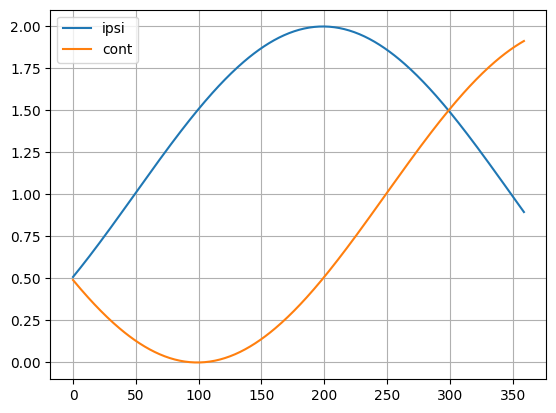

In [3]:
alpha_min = 0.
theta_min = 150
ear_angle_offset = 10

theta_array = np.linspace(1, 360, 360) 

theta_cont = 90 + theta_array / 2 + ear_angle_offset
theta_ipsi = 90 - theta_array / 2 + ear_angle_offset

alpha_ipsi = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos(np.pi * theta_ipsi / theta_min)
alpha_cont = (1 + alpha_min / 2) + (1 - alpha_min / 2) * np.cos(np.pi * theta_cont / theta_min)

plt.plot(alpha_ipsi, label="ipsi")
plt.plot(alpha_cont, label="cont")
plt.grid(True)
plt.legend()
plt.show()

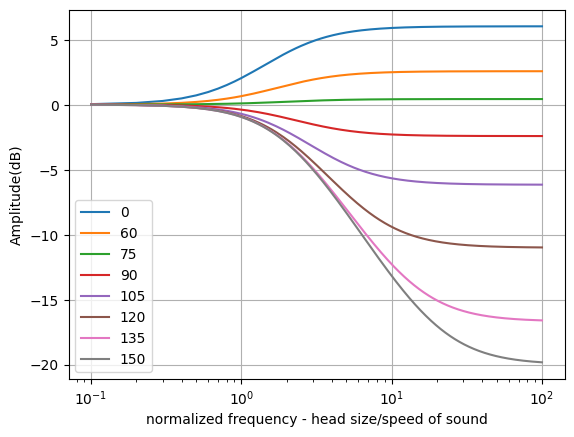

In [4]:
theta_array = np.array([0, 60, 75, 90, 105, 120, 135, 150])
x = np.arange(1, 1001) / 10
for theta in theta_array:
    h = compute_transfer_function(theta)
    a = 20 * np.log10(np.abs(h))
    plt.plot(x, a, label = str(theta))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - head size/speed of sound")
plt.show()

Based on the equations provided, the transfer function $H_{HS}(\omega, \theta) $ is derived and approximated in the z-domain as follows:

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{\alpha}{2 \omega_0}s}{1+\frac{1}{2 \omega_0}s} \\
&\approx \frac{1+\frac{\alpha}{2 \omega_0}\frac{2}{T} \frac{z-1}{z+1}}{1+\frac{1}{2 \omega_0}\frac{2}{T} \frac{z-1}{z+1}} \\
&= \frac{1+\frac{\alpha}{\omega_0}\frac{1}{T} \frac{z-1}{z+1}}{1+\frac{1}{\omega_0}\frac{1}{T} \frac{z-1}{z+1}} \\
&= \frac{\omega_0 T (z+1) + \alpha (z-1)}{ \omega_0 T (z+1) + (z-1) } \\
&= \frac{\alpha + \omega_0 T - ( \alpha - \omega_0 T )z^{-1}}{1 + \omega_0 T - ( 1 - \omega_0 T )z^{-1} } \\
&= \frac{\frac{\alpha + \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}} - \frac{\alpha - \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}}z^{-1}}
{1 - \frac{1 - \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}}z^{-1}}
\end{align}
$$

In [5]:
def compute_transfer_function_z(theta, alpha_min = 0.1, theta_min = 180, a = 0.0875, c = 343, sr = 44100):
    alpha = compute_alpha(theta, alpha_min, theta_min)
    w0 = c / a

    b = [(alpha+w0/sr)/(1+w0/sr), -(alpha-w0/sr)/(1+w0/sr)]
    a = [1, -(1-w0/sr)/(1+w0/sr)]
    
    return b, a

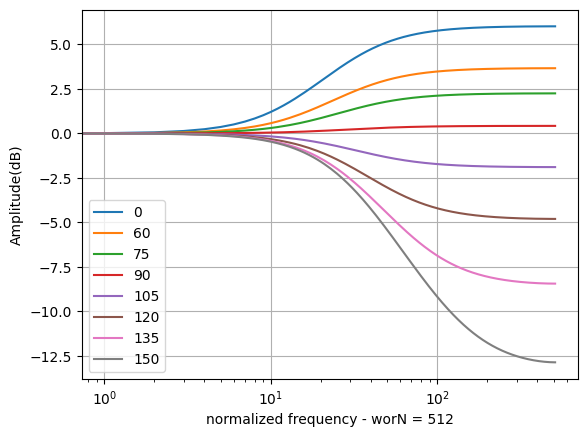

In [6]:
for theta in theta_array:
    b, a = compute_transfer_function_z(theta)
    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(theta))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()

$$
\frac{H_\text{front}}{H_\text{rear}} = \frac{\frac{H_{b_\text{front}}}{H_{a_\text{front}}}}{\frac{H_{b_\text{rear}}}{H_{a_\text{rear}}}} = \frac{H_{b_\text{front}}H_{a_\text{rear}}}{H_{a_\text{front}}H_{b_\text{rear}}}
$$

In [7]:
spk_2_spk_dist = 40
aud_2_spk_dist = 15

# Calculate the angle in radians using arctan
angle_rad = np.arctan(spk_2_spk_dist * 0.5 / aud_2_spk_dist)

# Convert the angle to degrees
angle_deg = np.degrees(angle_rad)

# Convert to interaural system
rear_interaural = 180 - angle_deg

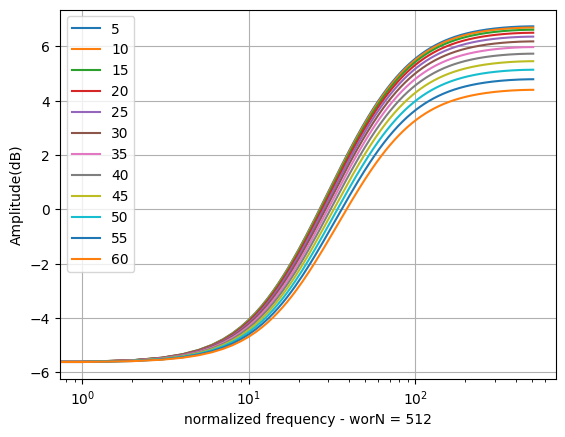

In [8]:
for index in range(12):
    front_interaural = index * 5 + 5
    b_r, a_r = compute_transfer_function_z(rear_interaural)
    b_f, a_f = compute_transfer_function_z(front_interaural)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(index*5+5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()

In [9]:
# Assume the speaker span is fixed
front_interaural = 30

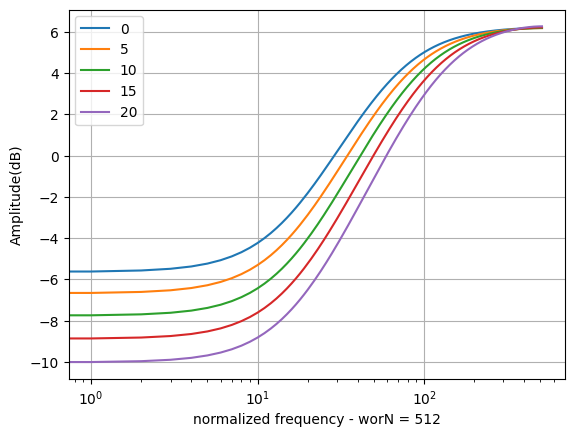

In [10]:
# Head rotates in counterclockwise

for inc in range(5):
    front_interaural_rotate = front_interaural + inc * 5
    rear_interaural_rotate = rear_interaural + inc * 5
    b_r, a_r = compute_transfer_function_z(rear_interaural_rotate)
    b_f, a_f = compute_transfer_function_z(front_interaural_rotate)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(inc*5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()

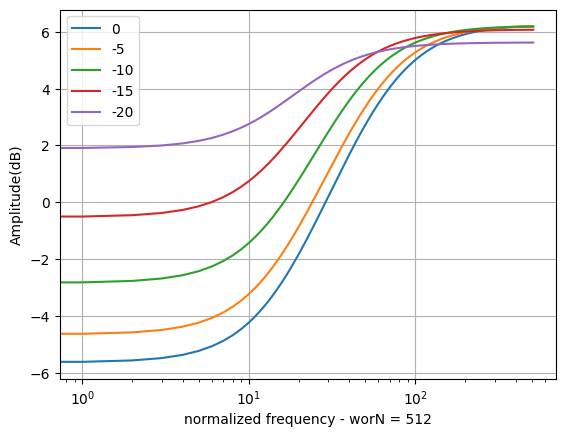

In [11]:
# Head rotates in anti-counterclockwise

for dec in range(5):
    front_interaural = front_interaural - dec * 5
    rear_interaural = rear_interaural - dec * 5
    b_r, a_r = compute_transfer_function_z(rear_interaural)
    b_f, a_f = compute_transfer_function_z(front_interaural)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(-dec*5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()